# ДЗ
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [219]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [55]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [56]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [57]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [58]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [86]:
# Функция определения Лучших пар-ов 
def best_params(y_test, y_score, b=1):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, y_score)]
#print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix], precision[ix], recall[ix]))

In [71]:
# 1 Логистическая регрессия
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [89]:
fpr1, tpr1, thresholds_1 = roc_curve(y_test, y_score, pos_label=1)
best_1=best_params(y_test.values, y_score)
best_1

[0.7303229695112764,
 0.6474307596402173,
 0.8375576036866359,
 0.7840347790421852]

In [90]:
# 2 Градиентный бустинг! (относительно долго выполняется)
classifier1 = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier1, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier1.fit(X_train, y_train)
y_score = classifier1.predict_proba(X_test)[:, 1]

CV score is 0.8025125910838183+-0.00707472977074522


In [91]:
fpr2, tpr2, thresholds_2 = roc_curve(y_test, y_score, pos_label=1)
best_2=best_params(y_test.values, y_score)
best_2

[0.7402477952713303,
 0.6978475976741814,
 0.7881336405529954,
 0.8026153641179974]

In [220]:
# 3 Дерево решений. 
classifier2 = Pipeline([
    ('features',feats),
    ('classifier', DecisionTreeClassifier(random_state = 42, max_depth = 7)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier2, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier2.fit(X_train, y_train)
y_score = classifier2.predict_proba(X_test)[:, 1]

CV score is 0.7928912815238747+-0.006721986411602513


In [222]:
fpr3, tpr3, thresholds_3 = roc_curve(y_test, y_score, pos_label=1)
best_3=best_params(y_test.values, y_score)
best_3

[0.7325457587588096, 0.6541700624830209, 0.832258064516129, 0.7932995613760097]

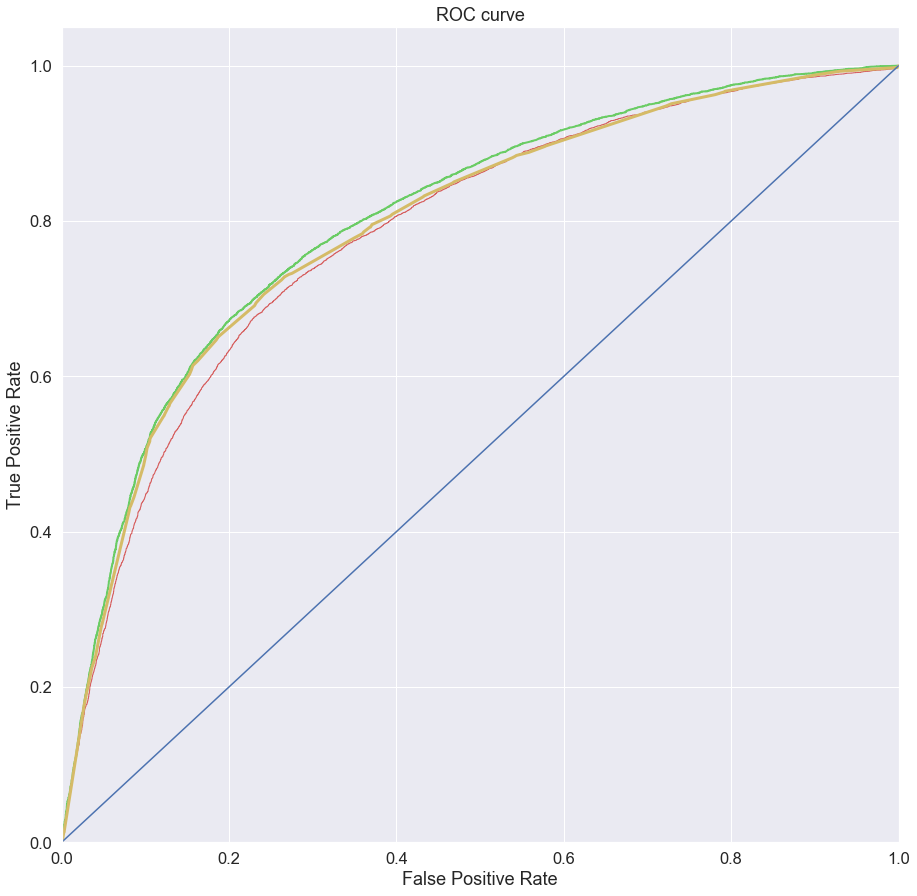

In [223]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(15, 15))
plt.plot(fpr1, tpr1, lw=1, color='r',  label='loglos_ROC curve ')
plt.plot(fpr2, tpr2, lw=2, color='g', label='GradB_ROC curve ')
plt.plot(fpr3, tpr3, lw=3, color='y', label='Tree_ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [234]:
# Общая таблица результатов
report= pd.DataFrame({'Логистическая регрессия': best_1, 'Градиентный бустинг': best_2, 'Дерево решений': best_3}).T
report.columns =['f1','presision','recall', 'roc_auc_score']
report

,f1,presision,recall,roc_auc_score
Логистическая регрессия,0.730323,0.647431,0.837558,0.784035
Градиентный бустинг,0.740248,0.697848,0.788134,0.802615
Дерево решений,0.732546,0.654170,0.832258,0.793300


Лучше всего с незначительным перевосом справляется "Градиентный бустинг"

метрика _precision_recall_curve_ лушче подходит для анализа несбалансированной выборки. Позволяет посмотреть как на точность, так и на полноту данных и в Зависимости от БИЗНЕС задачи сделать упол на тот или другой парраметр. При анализе _roc_auc_ позволяет легко оценить качесво модели по сранению с другими моделями. Как показанно выше, чем она ближе к Верхнему левому углу, тем больше точности у модели при прочих равных... Тем лучше она будет работать на практике...